# Bài toán dự đoán chất lượng nước 
Link dataset : https://www.kaggle.com/datasets/adityakadiwal/water-potability

### Các cột trong Dataset : 
ph                 : độ PH của nước (0 đến 14)\
Hardness           : Tỉ lệ các ion nước cứng có thể kết tủa(mg/L)\
Solids             : Lượng chất rắn hòa tan (ppm)\
Chloramines        : Lượng Chloramine (ppm)\
Sulfate            : Tỉ lệ SO4(2-) hòa tan (mg/L)\
Conductivity       : Độ dẫn điện của nước (μS/cm)\
Organic_carbon     : Lượng cacbon hữu cơ hòa tan (ppm)\
Trihalomethanes    : Lượng Trihalomethane hòa tan (μg/L)\
Turbidity          : Độ đục của nước \
Potability         : Chất lượng nước ( 0 : không an toàn, 1 : an toàn)

### Nạp các thư viện cần thiết

In [76]:
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(561)
sns.set(rc={"figure.figsize":(10, 8)})

In [77]:
dataset = pd.read_csv("./water_potability.csv")
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [78]:
print("Kích thước dataset : ", dataset.shape)

Kích thước dataset :  (3276, 10)


## Xử lý dữ liệu trống

In [79]:
dataset.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [80]:
dataset.dropna(axis=0, inplace=True)
print(dataset.shape)
print(dataset.isna().sum())

(2011, 10)
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


## Xử lý dữ liệu mất cân bằng

<AxesSubplot:xlabel='Potability', ylabel='count'>

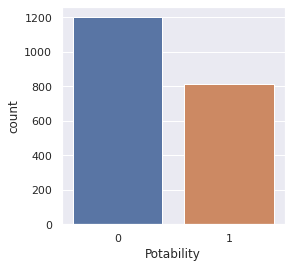

In [81]:
plt.figure(figsize=(4, 4))
sns.countplot(data=dataset, x="Potability")

<AxesSubplot:xlabel='Potability', ylabel='count'>

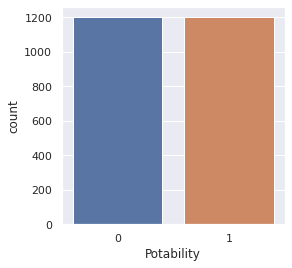

In [82]:
dirty_water = dataset[dataset["Potability"] == 0]  
clean_water = dataset[dataset["Potability"] == 1]  
# Resample lại tập clean_water sao cho số phần từ của nó bằng số phần tử tập dirty_water
one_upsampled = resample(clean_water, replace=True, n_samples=len(dirty_water))
# Nối tập vừa resample với tập dirty_water
dataset = pd.concat([dirty_water, one_upsampled])
# Xáo trộn ngẫu nhiên lại dataset
dataset = shuffle(dataset)  

plt.figure(figsize=(4, 4))
sns.countplot(data=dataset, x="Potability")

## Chia dữ liệu Train / Test

Chia theo tỉ lệ 20/80, stratify theo Potability để tỉ lệ nước uống được/không uống được bằng nhau ở 2 tập train và test

In [83]:
X_train, X_test, Y_train, Y_test=train_test_split(
    dataset[["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]].fillna(0),
    dataset["Potability"],test_size=0.2, stratify=dataset["Potability"], random_state=42)

X_train.shape, X_test.shape

((1920, 9), (480, 9))

<AxesSubplot:ylabel='Potability'>

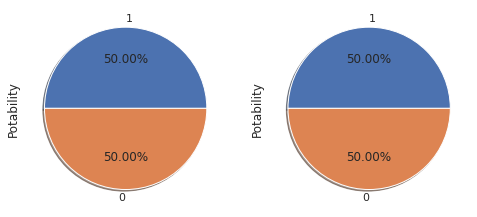

In [84]:
plt.subplot(1, 2, 1)
Y_train_percent = Y_train.value_counts()
Y_train_percent.plot.pie(figsize=(8, 8), shadow=True, autopct='%1.2f%%')

plt.subplot(1, 2, 2)
Y_test_percent = Y_test.value_counts()
Y_test_percent.plot.pie(figsize=(8, 8), shadow=True, autopct='%1.2f%%')

## Xử lý Outlier cho tập Train, tập Test giữ nguyên Outlier : 

In [85]:
X_columns = list(X_train.columns)
print(X_columns)

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


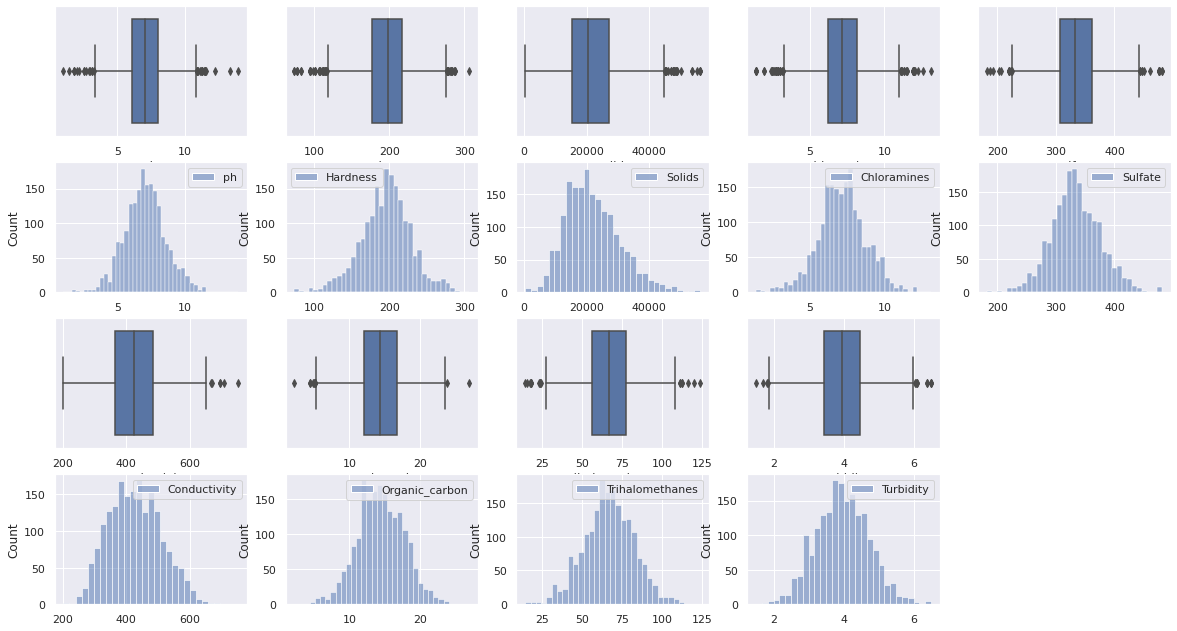

In [86]:
plt.figure(figsize=(20, 11))
j = 0
k = 5
for i in range(len(X_columns)):
    if i == 5:
        j = 5
        k = 10
    X_i = X_train[X_columns[i]].dropna()
    plt.subplot(4, 5, i+j+1)
    sns.boxplot(data=X_train, x=X_columns[i])
    plt.subplot(4, 5, i+k+1)
    sns.histplot(data=X_train[[X_columns[i]]])

Ta thấy hầu hết cột dữ liệu đều có dạng phân bố chuẩn, chỉ có Solids là có phân bố hơi lệch trái

In [87]:
def Remove_Outlier(dataset):
    data = dataset.copy()
    for col in X_columns:
        lower_boundary = round(data[col].mean() - 3* data[col].std())
        upper_boundary = round(data[col].mean() + 3 * data[col].std())
        data.loc[data[col] <= lower_boundary, col] = lower_boundary
        data.loc[data[col]>=upper_boundary, col] = upper_boundary
    return data

In [88]:
X_train_outlier = Remove_Outlier(X_train)
X_train_outlier.shape

(1920, 9)

## Tương quan giữa các biến

<AxesSubplot:title={'center':'Bản đồ nhiệt tương quan giữa các biến'}>

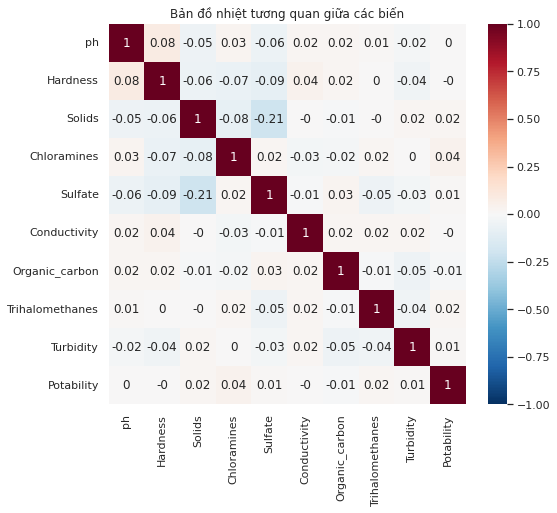

In [89]:
plt.figure(figsize=(8, 7))
plt.title("Bản đồ nhiệt tương quan giữa các biến")
sns.heatmap(dataset.corr().round(2), data=dataset, annot=True, vmin=-1.0, vmax=1.0, center=0, cmap='RdBu_r')

Các biến có mức độ tương quan thấp

## Chuẩn hóa Z-score

In [90]:
X_test_outlier = X_test.copy()

# Hàm chuẩn hóa
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# Sử dụng lại chính scaler của tập Train để chuẩn hóa cho tập Test
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Hàm chuẩn hóa
scaler = StandardScaler()
scaler.fit(X_train_outlier)
X_train_outlier = pd.DataFrame(scaler.transform(X_train_outlier), columns=X_train_outlier.columns)
# Sử dụng lại chính scaler của tập Train để chuẩn hóa cho tập Test
X_test_outlier = pd.DataFrame(scaler.transform(X_test_outlier), columns=X_test_outlier.columns)

## Hyperparameter Tuning

In [91]:
def acc(accuracy):
    return f"{round(accuracy*100, 2)} (%)"

In [92]:
def hyperparameter_tuning_rfc2(XTrain, YTrain, XTest, YTest):
    random_forest = RandomForestClassifier(random_state=42)
    params = {
        "n_estimators": [100, 200, 300, 400], 
        "min_samples_leaf": [1, 2, 10]
    }
    search = GridSearchCV(estimator=random_forest, param_grid=params, cv=5, n_jobs=-1)
    search.fit(XTrain, YTrain)
    # Kết quả Tuning tốt nhất
    print(f">> Best : {acc(search.best_score_)} using {search.best_params_}")
    print(f">> Test set : {acc(search.score(XTest, YTest))}")
    return search.best_params_


best_params_1 = hyperparameter_tuning_rfc2(X_train, Y_train, X_test, Y_test)
best_params_2 = hyperparameter_tuning_rfc2(X_train_outlier, Y_train, X_test_outlier, Y_test)

>> Best : 80.16 (%) using {'min_samples_leaf': 1, 'n_estimators': 400}
>> Test set : 81.88 (%)
>> Best : 80.16 (%) using {'min_samples_leaf': 1, 'n_estimators': 400}
>> Test set : 82.08 (%)


## Xây dựng Model

In [93]:
def build_model(XTrain, YTrain, XTest, YTest, best_params):
    model = RandomForestClassifier(
        n_estimators=best_params["n_estimators"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=42)
        
    model.fit(XTrain, YTrain)
    predictions = model.predict(XTest)
    score = accuracy_score(YTest, predictions)
    print(acc(score))


build_model(X_train, Y_train, X_test, Y_test, best_params_1)
build_model(X_train_outlier, Y_train, X_test_outlier, Y_test, best_params_2)

81.88 (%)
82.08 (%)
